In [1]:
import sys
sys.path.append('..')

import numpy as np
import os
from time import time
from collections import Counter
import random
from matplotlib import pyplot as plt

from lib.data_utils import shuffle
#from lib.config import data_dir

def mnist():
    fd = open(os.path.join('train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trX = loaded[16:].reshape((60000,28*28)).astype(float)

    fd = open(os.path.join('train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join('t10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teX = loaded[16:].reshape((10000,28*28)).astype(float)

    fd = open(os.path.join('t10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teY = loaded[8:].reshape((10000))
    
    trY = np.asarray(trY)
    teY = np.asarray(teY)

    return trX, teX, trY, teY

def mnist_with_valid_set():
    trX, teX, trY, teY = mnist()

    trX, trY = shuffle(trX, trY)
    vaX = trX[50000:]
    vaY = trY[50000:]
    trX = trX[:50000]
    trY = trY[:50000]

    return trX, vaX, teX, trY, vaY, teY

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpthm9sa/265abc51f7c376c224983485238ff1a5.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpthm9sa/265abc51f7c376c224983485238ff1a5.exp

Using gpu device 0: Quadro K2000 (CNMeM is disabled, cuDNN 5005)


In [2]:
#data_dir='/home/dcgan_code-master/mnist'
import theano
theano.config.floatX='float32'
theano.config.floatX

'float32'

In [3]:
trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()
import cv2
data2=np.zeros((100,64*64))
trX=trX/255
trX[trX>=0.5]=1
trX[trX<=0.5]=0
%matplotlib inline
for i in range(100):
    XXX=trX[i,:].reshape(28,28)
    temp=cv2.resize(XXX,(64,64))
    temp[temp>=0.5]=1
    temp[temp<=0.5]=0
    data2[i,:]=temp.reshape(-1)

In [4]:
import numpy as np
import theano
import theano.tensor as tensor
from theano.tensor.signal.pool import pool_2d
from theano.tensor.nnet import conv2d

def conv( x, w, b=None ):
    s = int(np.floor(w.get_value().shape[-1]/2.))
    z = conv2d(x, w, border_mode='full')[:, :, s:-s, s:-s]
    if b is not None:
        z += b.dimshuffle('x', 0, 'x', 'x')
    
    return z
        
def max_pool( x, size, ignore_border=False ):
    return pool_2d( x, size, ignore_border=ignore_border )

def rectify( x ):
    return (x + abs(x)) / 2.0

def batchnorm( x, g=None, b=None, eps=1e-8 ):
    if x.ndim == 4:
        m = tensor.mean(x, axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')
        v = tensor.mean(tensor.sqr(x - m), 
                          axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')

        x = (x - m) / tensor.sqrt( v + eps )
        if g is not None and b is not None:
            x = x*g.dimshuffle('x', 0, 'x', 'x') + b.dimshuffle('x', 0, 'x', 'x')

    elif x.ndim == 2:
        m = tensor.mean(x, axis=0)
        v = tensor.mean(tensor.sqr(x - m), axis=0)

        x = (x - m) / tensor.sqrt( v + eps )
        if g is not None and b is not None:
            x = x*g + b

    return x

def depool( x, factor=2 ):
    """
    This code is from 
    https://gist.github.com/kastnerkyle/f3f67424adda343fef40
    """
    output_shape = [
        x.shape[1],
        x.shape[2]*factor,
        x.shape[3]*factor
    ]
    stride = x.shape[2]
    offset = x.shape[3]
    in_dim = stride * offset
    out_dim = in_dim * factor * factor

    upsamp_matrix = tensor.zeros((in_dim, out_dim))
    rows = tensor.arange(in_dim)
    cols = rows*factor + (rows/stride * factor * offset)
    upsamp_matrix = tensor.set_subtensor(upsamp_matrix[rows, cols], 1.)

    flat = tensor.reshape(x, (x.shape[0], output_shape[0], x.shape[2] * x.shape[3]))

    up_flat = tensor.dot(flat, upsamp_matrix)
    upsamp = tensor.reshape(up_flat, (x.shape[0], output_shape[0],
                                      output_shape[1], output_shape[2]))

    return upsamp

def full_conn( x, w, b=None ):
    return tensor.dot( x, w ) + b

In [22]:
trX.reshape(-1, nc, npx, npx).shape

(10L, 1L, 64L, 64L)

In [73]:
import sys
sys.path.append('..')

import os
import json
import scipy.io
from time import time
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.externals import joblib

import math
import theano
import theano.tensor as T
from theano.sandbox.cuda.dnn import dnn_conv

from lib import activations
from lib import updates
from lib import inits
from lib.vis import grayscale_grid_vis
from lib.rng import py_rng, np_rng
from lib.ops import conv_cond_concat, deconv, dropout
from lib.theano_utils import floatX, sharedX
from lib.data_utils import OneHot, shuffle, iter_data
from lib.metrics import nnc_score, nnd_score
np.set_printoptions(threshold='nan')
#from load import mnist_with_valid_set

#trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()

#image = scipy.io.loadmat('WB_test64_GAN.mat')
#data1=np.abs(image['WB_test64_GAN']-1)

vaX= data2[0:100]
trX= data2[0:100]
#vaX= data2
#trX= data2
vaX = floatX(vaX)

k = 1             # # of discrim updates for each gen update
l2 = 2.5e-5       # l2 weight decay
b1 = 0.5          # momentum term of adam
nc = 1            # # of channels in image
#ny = 10           # # of classes
nbatch = 10      # # of examples in batch
npx = 64          # # of pixels width/height of images
nz = 1000          # # of dim for Z
ngfc = 1024       # # of gen units for fully connected layers
ndfc = 1024       # # of discrim units for fully connected layers
ngf = 40          # # of gen filters in first conv layer
ndf = 40          # # of discrim filters in first conv layer
nx = npx*npx*nc   # # of dimensions in X
niter = 10000       # # of iter at starting learning rate
niter_decay = 1 # # of iter to linearly decay learning rate to zero
lr = 0.0001       # initial learning rate for adam
#ntrain, nval, ntest = len(trX), len(vaX), len(teX)
ntrain = len(trX)

def transform(X):
    return (floatX(X)).reshape(-1, nc, npx, npx)
    #return (floatX(X)).reshape(-1, nc, npx, npx)
def inverse_transform(X):
    X = X.reshape(-1, npx, npx)
    return X

# if not os.path.exists('logs/'):
#     os.makedirs('logs/')
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)
# if not os.path.exists(samples_dir):
#     os.makedirs(samples_dir)

relu = activations.Rectify()
sigmoid = activations.Sigmoid()
lrelu = activations.LeakyRectify()

bce = T.nnet.binary_crossentropy
tanh = activations.Tanh()

eifn = inits.Normal(scale=0.02)
gifn = inits.Normal(scale=0.02)
difn = inits.Normal(scale=0.02)
gain_ifn = inits.Normal(loc=1., scale=0.02)
bias_ifn = inits.Constant(c=0.)

#encoder
ew  = difn((ndf, nc, 5, 5), 'ew')
eg1 = gain_ifn((ndf), 'eg1')
eb1 = bias_ifn((ndf), 'eb1')
ew2 = difn((ndf*2, ndf, 5, 5), 'ew2')
eg2 = gain_ifn((ndf*2), 'eg2')
eb2 = bias_ifn((ndf*2), 'eb2')
ew3 = difn((ndf*4, ndf*2,5,5), 'ew3')
eg3 = gain_ifn((ndf*4), 'eg3')
eb3 = bias_ifn((ndf*4), 'eb3')
ew4 = difn((ndf*4*8*8, 1000), 'ew4')
eb4 = bias_ifn((1000), 'eb4')
bwe4= eifn((1000),'bwe4')
bbe4= bias_ifn((1000),'bbe4')
wmu = difn((1000, nz), 'wmu')
bmu = bias_ifn((nz), 'bmu')


wd4 = gifn((nz, ndf*4*8*8), 'wd4')
bd4 = bias_ifn((ndf*4*8*8),'bd4')
bwd4 = gifn((ndf*4*8*8), 'bwd4')
bbd4 = bias_ifn((ndf*4*8*8), 'bbd4')
wd3 = gifn((ngf*4, ngf*4, 5, 5), 'wd3')
bwd3 = gain_ifn((ngf*4), 'bwd3')
bbd3 = bias_ifn((ngf*4), 'bbd3')
wd2 = gifn((ngf*2, ngf*4, 5, 5), 'wd2')
bwd2 = gain_ifn((ngf*2), 'bwd2')
bbd2 = bias_ifn((ngf*2), 'bbd2')
wd1 = gifn((ngf, ngf*2, 5, 5),'wd1')
bwd1 = gain_ifn((ngf),'bwd1')
bbd1 = bias_ifn((ngf),'bbd1')
wd0 = gifn((nc,ngf,5,5), 'wd0')
bwd = bias_ifn((nc),'bwd')

X = T.tensor4()
Z = T.matrix()


ae_params = [ew, eb1, ew2, eb2, ew3, eb3, ew4, eb4, wmu, bmu,
             wd4, bd4, wd3, bbd3, wd2, bbd2, wd1, bbd1, wd0, bwd]

# def enc(X, w, g1, b1, w2, g2, b2, w3, g3, b3, w4, g4, b4, wmu, bmu):
def ae(X, w, b1, we2, b2, we3,b3, g4, b4, wmu, bmu, 
       wd4, bd4, wd3, bbd3, wd2, bbd2, wd1, bbd1, wd0, bwd):
    
#     h1 = rectify( batchnorm( max_pool( conv( X,  w ), (2,2) ), g1, b1 ) )
#     h2 = rectify( batchnorm( max_pool( conv( h1, we2 ), (2,2) ), g2, b2 ) )
#     h3  = rectify( batchnorm( max_pool( conv( h2, we3 ), (2,2) ), g3, b3 ) )
#     h3_ = h3.reshape((-1,8*8*160))
#     h4 = rectify(batchnorm( full_conn( h3_, g4, b4 ), bwe4, bbe4 ))   
#     mu = theano.dot( h4, wmu ) + bmu
    
#     h5  = rectify( batchnorm( full_conn( mu,  wd4, bd4 ), bwd4, bbd4 ) )
#     h5_ = h5.reshape( (-1,160, 8, 8) )
#     h6  = rectify( batchnorm( conv( depool( h5_, factor=2 ), wd3 ), bwd3, bbd3 ) )
#     h7  = rectify( batchnorm( conv( depool( h6 , factor=2 ), wd2 ), bwd2, bbd2 ) )
#     h8  = rectify( batchnorm( conv( depool( h7,  factor=2 ), wd1 ), bwd1, bbd1 ) )
#     x_tilde   = sigmoid( conv( h8, wd0 ) )
#     return x_tilde

    h1 = rectify(( max_pool( conv( X,  w, b1), (2,2) )) )
    h2 = rectify(( max_pool( conv( h1, we2, b2), (2,2) )) )
    h3  = rectify(( max_pool( conv( h2, we3, b3), (2,2) )) )
    h3_ = h3.reshape((-1,8*8*160))
    h4 = rectify(( full_conn( h3_, g4, b4 )))   
    mu = theano.dot( h4, wmu ) + bmu
    
    h5  = rectify(( full_conn( mu,  wd4, bd4 )) )
    h5_ = h5.reshape( (-1,160, 8, 8) )
    h6  = rectify(( conv( depool( h5_, factor=2 ), wd3, bbd3 )) )
    h7  = rectify(( conv( depool( h6 , factor=2 ), wd2, bbd2)) )
    h8  = rectify(( conv( depool( h7,  factor=2 ), wd1, bbd1 )) )
    x_tilde   = sigmoid( conv( h8, wd0, bwd ) )
    return x_tilde

X_tilde = ae(X, *ae_params)

xent_loss = bce(X_tilde, X).mean()

cost = [xent_loss]

lrt = sharedX(lr)
ae_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
ae_updates = ae_updater(ae_params, xent_loss)

updates = ae_updates

print 'COMPILING'
t = time()

_train_ae = theano.function([X], xent_loss, updates=ae_updates)

#_enc = theano.function([X], encZ_mu)
#_gen = theano.function([encZ_mu], X_tilde)
_ae = theano.function([X],X_tilde)
print '%.2f seconds to compile theano functions'%(time()-t)

n_updates = 0
n_check = 0
n_epochs = 0
n_updates = 0
n_examples = 0
ae_cost_error=[]
gen_cost_error=[]
dis_cost_error=[]
t = time()
iter_error=0
print 'start training......'
for epoch in range(1, 250):
    #trX = shuffle(trX)
    for imb in iter_data(trX, size=nbatch):
        imb = transform(imb)
        cost = _train_ae(imb)
        n_updates += 1
        n_examples += len(imb)
    #if (epoch-1) % 1 == 0:
        iter_error += 1
        ae_cost = float(cost)*64*64
        ae_cost_error.append(ae_cost)
        if (epoch) % 10 == 0:
            print '%.0f %.4f'%(epoch, ae_cost)  
                


c:\anaconda\lib\site-packages\ipykernel\__main__.py:58: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.


COMPILING
26.48 seconds to compile theano functions
start training......


KeyboardInterrupt: 

In [58]:
imb[1:2].shape

(1L, 1L, 64L, 64L)

In [71]:
XXX=trX[50].reshape(1,1, 64,64)
#XXX.dtype='float32'
XXX=XXX.astype(np.float32)
XXX.shape

(1L, 1L, 64L, 64L)

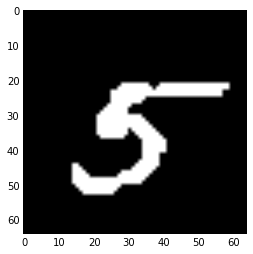

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(imb[1:2].reshape(64,64),'gray')

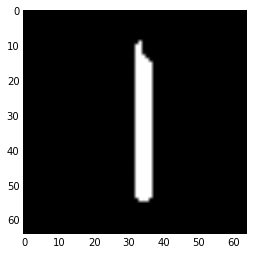

In [72]:
plt.imshow(_ae(XXX).reshape(64,64),'gray')

([array([ 64.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([ 64.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([ 64.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([ 64.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([ 64.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([ 64.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([ 64.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([ 64.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([ 64.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([ 64.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([ 64.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([ 64.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([ 64.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([ 64.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  arra

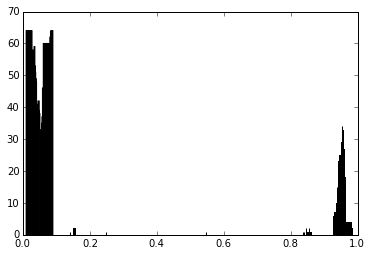

In [50]:
plt.hist(abs(_ae(imb[4:5]).reshape(64,64)**2-_ae(imb[1:2]).reshape(64,64)**2))

In [25]:
sampling_Z = _enc(imb[3:4])[0] + np.exp(_enc(imb[3:4])[1] / 2) 
plt.imshow(_gen(sampling_Z).reshape(64,64),'gray')

IndexError: index 1 is out of bounds for axis 0 with size 1

In [21]:
XX=_gen(sampling_Z)
XX[XX>=0.5]=1
XX[XX<0.5]=0
plt.imshow(XX.reshape(64,64),'gray')

NameError: name '_gen' is not defined

In [135]:
_gen(sampling_Z)

array([[[[  1.04351742e-02,   3.27859656e-03,   5.66081051e-03,
            3.35642695e-03,   6.55019656e-03,   1.40592963e-01,
            8.00606012e-02,   1.08846173e-01,   4.22248878e-02,
            2.36730445e-02,   1.21258525e-02,   1.25347711e-02,
            4.11498919e-03,   5.55675570e-03,   6.64217630e-03,
            9.72926524e-03,   9.35251918e-03,   3.45769487e-02,
            8.25480744e-03,   7.08866119e-03,   2.79962877e-03,
            1.55773270e-03,   8.60686530e-04,   1.49019191e-03,
            1.07091537e-03,   2.57703429e-03,   1.74984278e-03,
            3.65125970e-03,   3.51535971e-03,   1.00234877e-02,
            5.53965243e-03,   1.07467454e-02,   6.32586703e-03,
            8.11125524e-03,   2.01247679e-03,   2.56637973e-03,
            1.21862791e-03,   9.95066483e-04,   3.70700262e-04,
            8.24778399e-04,   4.37399023e-04,   7.03338068e-04,
            3.26274283e-04,   6.50097674e-04,   3.37248144e-04,
            6.53861964e-04,   3.41759966